In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

import numpy as np

#os.environ["OMP_NUM_THREADS"] = str(1)

import torch
import torch.nn as nn

torch.set_num_threads(1)
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_auc_score
SEED = 1
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

import json
import pandas as pd
import joblib
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout, Lambda

import tensorflow as tf
# device = torch.device('cpu')
# device = torch.device('cuda:0')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cpu = torch.device('cpu')
#'1.3.4' pandas version
def reset_random_seeds():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)



1 Physical GPUs, 1 Logical GPU


In [2]:
def get_fold_of_data(kfold_number):

    #FOLD_IDEX_PATH = '/home/churtado26/Data/PICAI/PICAI/picai_folds_indexes.json'
    #FOLD_IDEX_PATH = '/home/camedu/Data/cesar/picai_folds_indexes.json'
    FOLD_IDEX_PATH = '/home/jaolmosr_pupils/Cesar/picai_folds_indexes.json'

    fold_indexes = open(FOLD_IDEX_PATH, 'r')
    indexdes = json.load(fold_indexes)
    #indexdes.keys()

    training_target_kfold = 'Fold_{}_train'.format(kfold_number)
    validation_target_kfold = 'Fold_{}_val'.format(kfold_number)


    # REVISAR EL PSA EN EL JSON!!
    #BASE_PATH = '/home/churtado26/Data/PICAI/PICAI/patches/'
    BASE_PATH = '/home/jaolmosr_pupils/Cesar/'
    JSON_PATH = os.path.join(BASE_PATH, 'info-12x32x32.json')
    IMAGES_PATH = os.path.join(BASE_PATH, 'size-12x32x32')
    file = open(JSON_PATH, 'r')

    metadata = json.load(file)
    file_names = os.listdir(IMAGES_PATH)


    X_train = []
    Y_train = []
    
    ids_train = []
    ids_val = []

    X_validation = []
    Y_validation = []



    for patient_id in indexdes[training_target_kfold]:
        file_name = '{}.npy'.format(patient_id)
        img = np.load(os.path.join(IMAGES_PATH, file_name))
        X_train.append(img)
        ids_train.append(patient_id)

        y = metadata[patient_id]['label']
        Y_train.append(y)

    for patient_id in indexdes[validation_target_kfold]:
        file_name = '{}.npy'.format(patient_id)
        img = np.load(os.path.join(IMAGES_PATH, file_name))
        X_validation.append(img)
        ids_val.append(patient_id)

        y = metadata[patient_id]['label']
        Y_validation.append(y)
        
    return np.array(X_train), np.array(X_validation), np.array(Y_train), np.array(Y_validation), ids_train, ids_val




In [15]:
def plot_curves():
    import matplotlib.pyplot as plt
    
    # Plotting accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Plotting accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Training auc')
    plt.plot(history.history['val_auc'], label='Validation auc')
    plt.title('Auc-roc Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Auc-roc')
    plt.legend()


In [3]:
def create_model():
    input_shape = (12, 32, 32, 1)  # Input shape for each modality

    # Define a function to create a branch of the model
    def create_branch():
        branch = tf.keras.models.Sequential([
            tf.keras.layers.Conv3D(filters=8, kernel_size=(1,3,3), padding='SAME', input_shape=input_shape, dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=8, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(2,2,2)),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=64, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.GlobalAveragePooling3D()
        ])
        return branch

    # Create a branch for each modality
    t2_branch = create_branch()
    adc_branch = create_branch()
    bval_branch = create_branch()

    # Create inputs for each branch
    t2_input = tf.keras.layers.Input(input_shape)
    adc_input = tf.keras.layers.Input(input_shape)
    bval_input = tf.keras.layers.Input(input_shape)

    # Pass inputs through their respective branches
    t2_embedding = t2_branch(t2_input)
    adc_embedding = adc_branch(adc_input)
    bval_embedding = bval_branch(bval_input)

    # Concatenate the outputs of each branch
    fusion_embedding = tf.keras.layers.concatenate([t2_embedding, adc_embedding, bval_embedding])

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(fusion_embedding)

    # Create the model
    model = tf.keras.models.Model(inputs=[t2_input, adc_input, bval_input], outputs=output)
    
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


Entrenando en el Fold: 1
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8184 - auc: 0.8118
Epoch 1: val_auc improved from -inf to 0.54380, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_0.h5
33/33 [==============================] - 5s 68ms/step - loss: 0.4073 - accuracy: 0.8203 - auc: 0.8139 - val_loss: 0.5346 - val_accuracy: 0.8192 - val_auc: 0.5438
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.9014 - auc: 0.8994
Epoch 2: val_auc improved from 0.54380 to 0.60309, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_0.h5
33/33 [==============================] - 2s 59ms/step - loss: 0.2662 - accuracy: 0.9024 - auc: 0.8998 - val_loss: 0.4776 - val_accuracy: 0.8192 - val_auc: 0.6031
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9111 - auc: 0.9348
Epoch 3: val_au

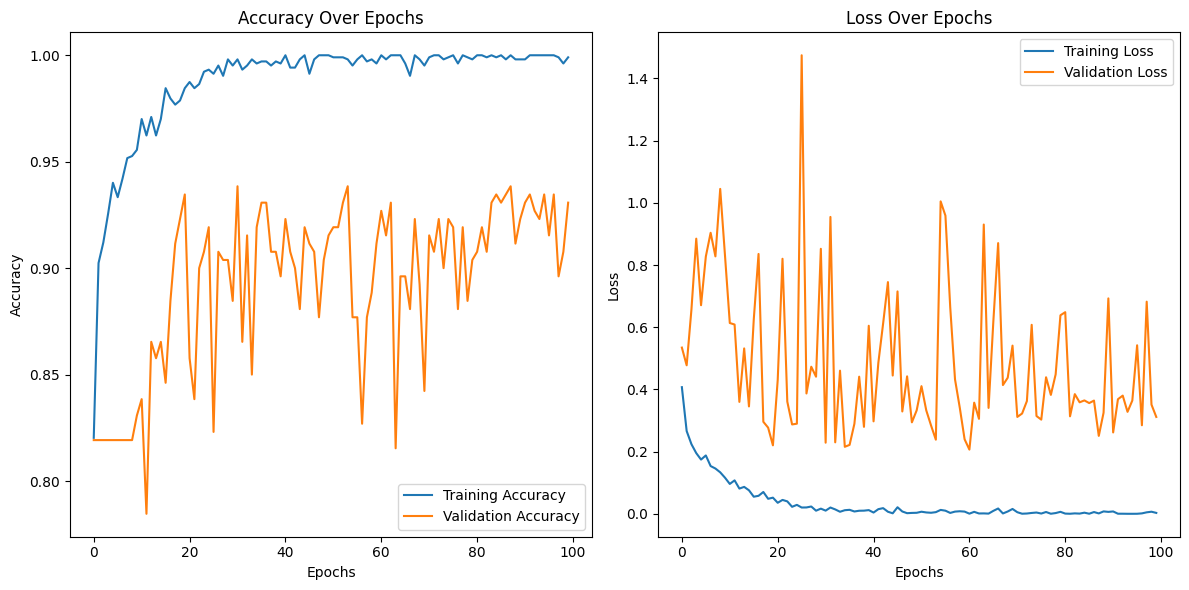

Entrenando en el Fold: 2
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8652 - auc: 0.8356
Epoch 1: val_auc improved from -inf to 0.26350, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_1.h5
33/33 [==============================] - 6s 68ms/step - loss: 0.3400 - accuracy: 0.8661 - auc: 0.8379 - val_loss: 0.4741 - val_accuracy: 0.8371 - val_auc: 0.2635
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2405 - accuracy: 0.9023 - auc: 0.9267
Epoch 2: val_auc improved from 0.26350 to 0.68036, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_1.h5
33/33 [==============================] - 2s 60ms/step - loss: 0.2411 - accuracy: 0.9020 - auc: 0.9274 - val_loss: 0.5498 - val_accuracy: 0.8371 - val_auc: 0.6804
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9102 - auc: 0.9455
Epoch 3: val_au

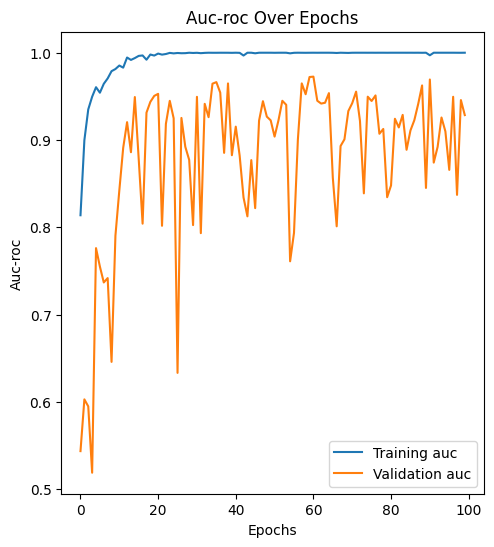

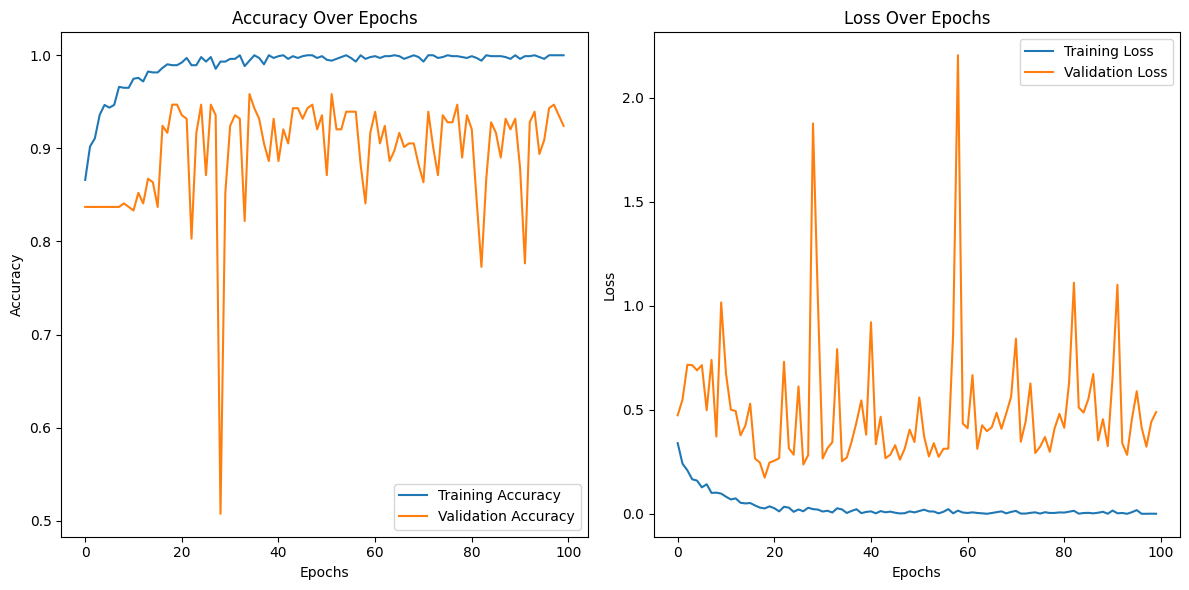

Entrenando en el Fold: 3
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8633 - auc: 0.8436
Epoch 1: val_auc improved from -inf to 0.69579, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_2.h5
33/33 [==============================] - 5s 68ms/step - loss: 0.3361 - accuracy: 0.8636 - auc: 0.8448 - val_loss: 0.4378 - val_accuracy: 0.8425 - val_auc: 0.6958
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9072 - auc: 0.9393
Epoch 2: val_auc improved from 0.69579 to 0.79410, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_2.h5
33/33 [==============================] - 2s 59ms/step - loss: 0.2271 - accuracy: 0.9068 - auc: 0.9382 - val_loss: 0.4529 - val_accuracy: 0.8425 - val_auc: 0.7941
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9189 - auc: 0.9437
Epoch 3: val_au

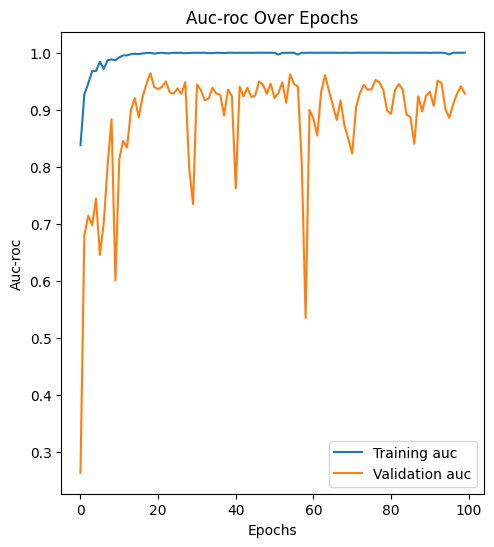

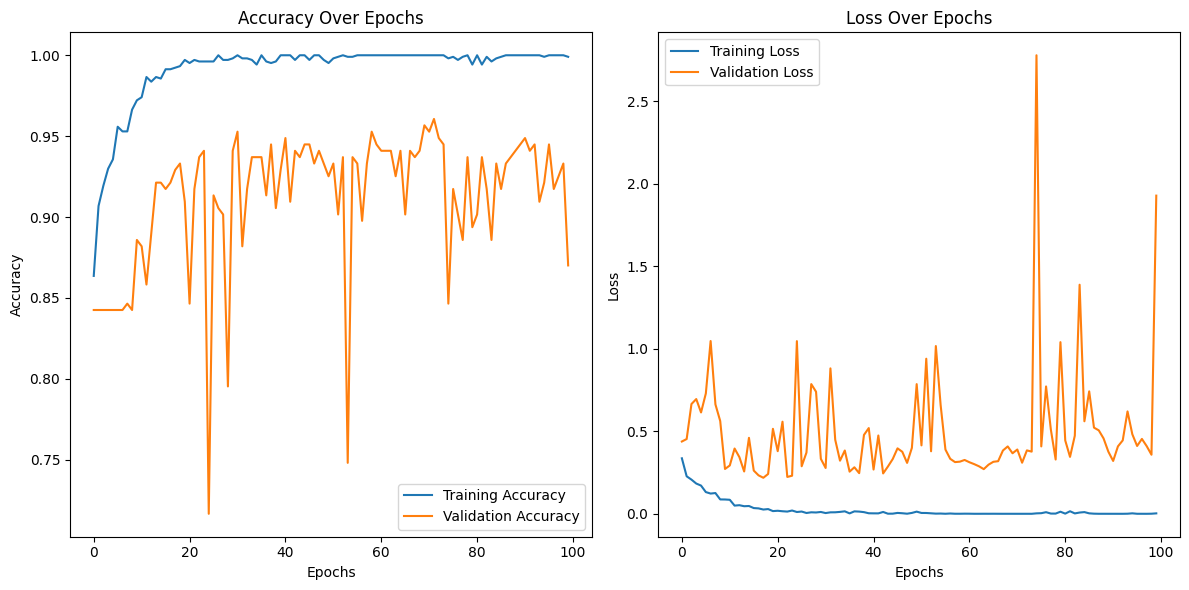

Entrenando en el Fold: 4
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8506 - auc: 0.8152
Epoch 1: val_auc improved from -inf to 0.51887, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_3.h5
33/33 [==============================] - 5s 68ms/step - loss: 0.3639 - accuracy: 0.8505 - auc: 0.8160 - val_loss: 0.4849 - val_accuracy: 0.8340 - val_auc: 0.5189
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.8945 - auc: 0.9147
Epoch 2: val_auc improved from 0.51887 to 0.53532, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_3.h5
33/33 [==============================] - 2s 59ms/step - loss: 0.2561 - accuracy: 0.8951 - auc: 0.9153 - val_loss: 0.4834 - val_accuracy: 0.8340 - val_auc: 0.5353
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9180 - auc: 0.9380
Epoch 3: val_au

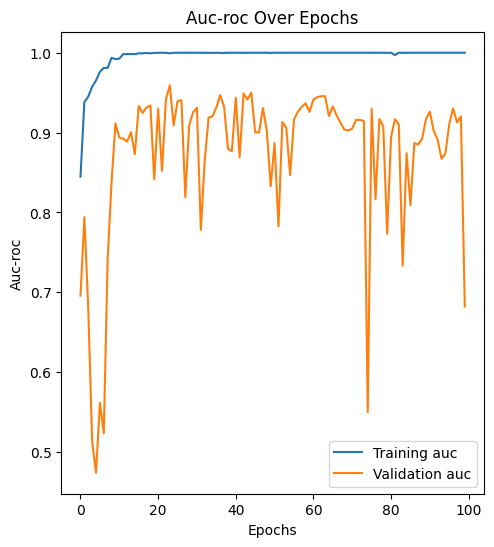

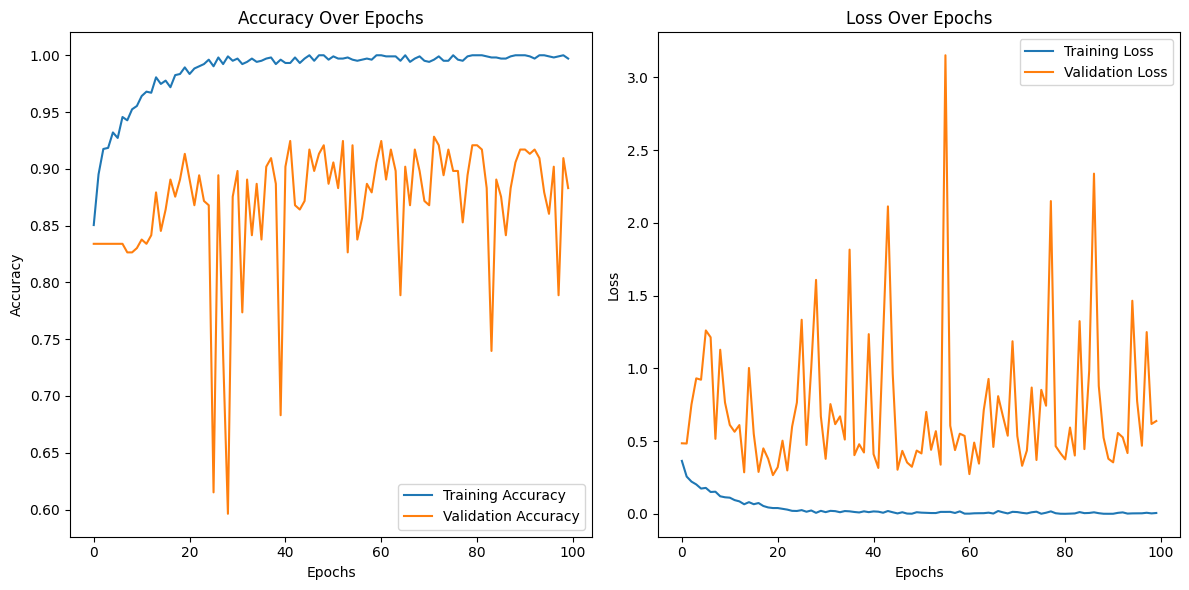

Entrenando en el Fold: 5
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.4085 - accuracy: 0.8086 - auc: 0.7964
Epoch 1: val_auc improved from -inf to 0.29174, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_4.h5
33/33 [==============================] - 6s 69ms/step - loss: 0.4053 - accuracy: 0.8102 - auc: 0.8002 - val_loss: 0.5130 - val_accuracy: 0.8175 - val_auc: 0.2917
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.2638 - accuracy: 0.9062 - auc: 0.9091
Epoch 2: val_auc improved from 0.29174 to 0.36292, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities/all_modalities_fold_4.h5
33/33 [==============================] - 2s 59ms/step - loss: 0.2644 - accuracy: 0.9060 - auc: 0.9077 - val_loss: 0.6598 - val_accuracy: 0.8175 - val_auc: 0.3629
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9238 - auc: 0.9484
Epoch 3: val_au

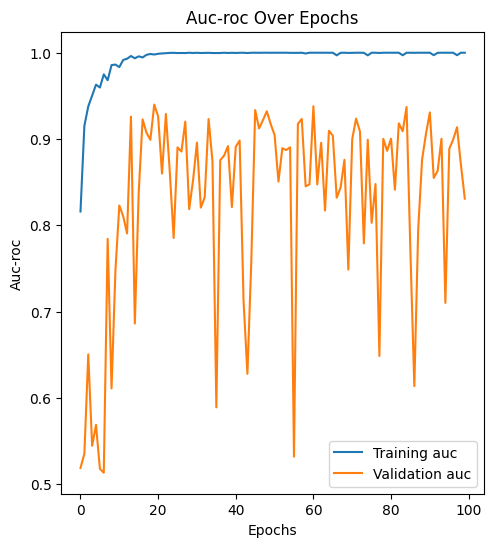

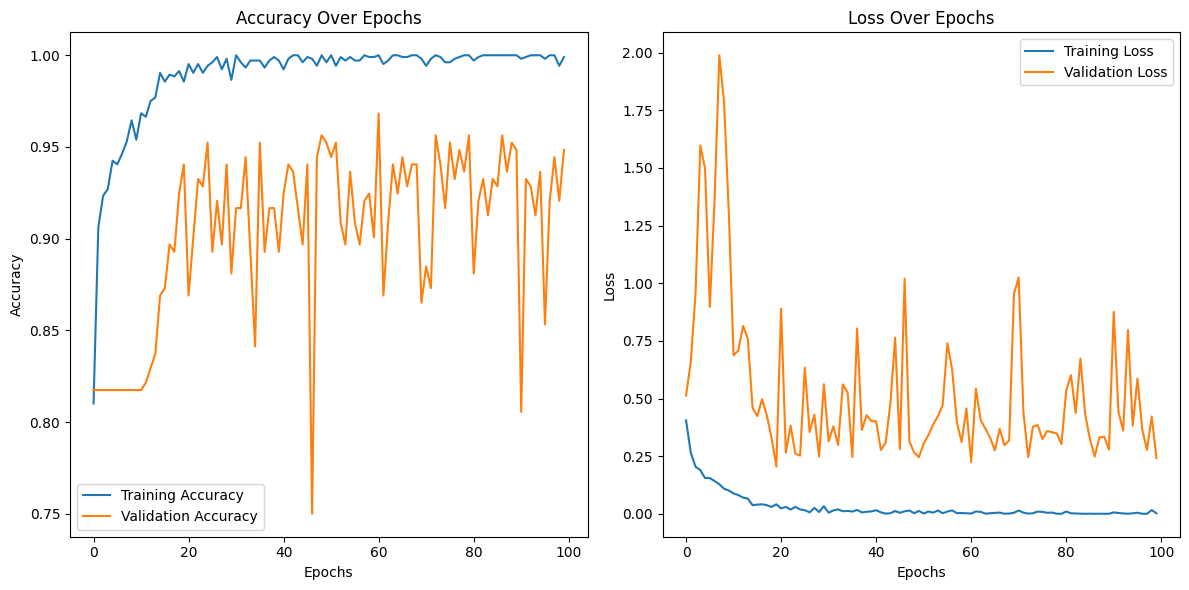

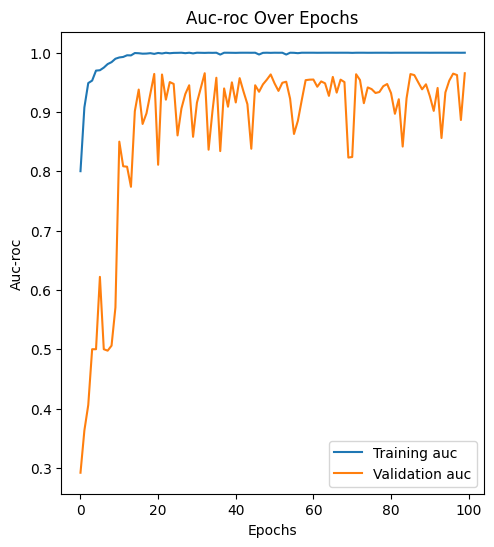

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities'
os.makedirs(save_dir, exist_ok=True)

for kfold_number in range(5):
    print(f"Entrenando en el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_train = np.transpose(X_train, (0, 2, 3, 4, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Crear el modelo
    model = create_model()

    model.optimizer.build(model.trainable_variables)

    # Crear el callback para guardar el mejor modelo
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'all_modalities_fold_{kfold_number}.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Ajustar el modelo
    history = model.fit(
        [X_train[..., 0], X_train[..., 1], X_train[..., 2]], 
        Y_train, 
        epochs=100, 
        validation_data=([X_val[..., 0], X_val[..., 1], X_val[..., 2]], Y_val), 
        batch_size=32,
        callbacks=[checkpoint_callback]
    )
    plot_curves()


# Metrics report

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/all_modalities'

for kfold_number in range(5):
    print(f"Generando informe para el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Cargar el modelo
    model = load_model(os.path.join(save_dir, f'all_modalities_fold_{kfold_number}.h5'))

    # Predecir las etiquetas de los datos de validación
    Y_pred = model.predict([X_val[..., 0], X_val[..., 1], X_val[..., 2]])

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(Y_val, Y_pred)

    # Redondear las predicciones para calcular precisión, recall y accuracy
    Y_pred = np.round(Y_pred)

    # Generar el informe de clasificación
    report = classification_report(Y_val, Y_pred, target_names=['Clase 0', 'Clase 1'])

    print(f"Informe para el Fold {kfold_number + 1}:\n{report}")
    print(f"AUC-ROC: {auc_roc}\n")


Generando informe para el Fold: 1
9/9 [==============================] - 0s 17ms/step
Informe para el Fold 1:
              precision    recall  f1-score   support

     Clase 0       0.96      0.95      0.96       213
     Clase 1       0.78      0.83      0.80        47

    accuracy                           0.93       260
   macro avg       0.87      0.89      0.88       260
weighted avg       0.93      0.93      0.93       260

AUC-ROC: 0.9734292278493657

Generando informe para el Fold: 2
9/9 [==============================] - 0s 16ms/step
Informe para el Fold 2:
              precision    recall  f1-score   support

     Clase 0       0.96      0.98      0.97       221
     Clase 1       0.87      0.79      0.83        43

    accuracy                           0.95       264
   macro avg       0.92      0.88      0.90       264
weighted avg       0.95      0.95      0.95       264

AUC-ROC: 0.9628538356308535

Generando informe para el Fold: 3
8/8 [=============================

# Solo con T2

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def create_model_t2():
    input_shape = (12, 32, 32, 1)  # Input shape for each modality

    # Define a function to create a branch of the model
    def create_branch_t2():
        branch = tf.keras.models.Sequential([
            tf.keras.layers.Conv3D(filters=8, kernel_size=(1,3,3), padding='SAME', input_shape=input_shape, dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=8, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(2,2,2)),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=64, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.GlobalAveragePooling3D()
        ])
        return branch

    # Create a branch for the t2 modality
    t2_branch = create_branch_t2()

    # Create input for the branch
    t2_input = tf.keras.layers.Input(input_shape)

    # Pass input through the branch
    t2_embedding = t2_branch(t2_input)

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(t2_embedding)

    # Create the model
    model = tf.keras.models.Model(inputs=t2_input, outputs=output)
    
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model



Entrenando en el Fold: 1
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7498 - auc: 0.5905
Epoch 1: val_auc improved from -inf to 0.48921, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_0.h5
33/33 [==============================] - 2s 30ms/step - loss: 0.5421 - accuracy: 0.7498 - auc: 0.5905 - val_loss: 0.6160 - val_accuracy: 0.8192 - val_auc: 0.4892
Epoch 2/100
 7/33 [=====>........................] - ETA: 0s - loss: 0.3957 - accuracy: 0.8616 - auc: 0.7265

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8512 - auc: 0.7058
Epoch 2: val_auc did not improve from 0.48921
33/33 [==============================] - 1s 22ms/step - loss: 0.4063 - accuracy: 0.8512 - auc: 0.7058 - val_loss: 0.5464 - val_accuracy: 0.8192 - val_auc: 0.4637
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3537 - accuracy: 0.8599 - auc: 0.8129
Epoch 3: val_auc improved from 0.48921 to 0.53087, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_0.h5
33/33 [==============================] - 1s 23ms/step - loss: 0.3536 - accuracy: 0.8618 - auc: 0.8094 - val_loss: 0.4722 - val_accuracy: 0.8192 - val_auc: 0.5309
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3283 - accuracy: 0.8659 - auc: 0.8446
Epoch 4: val_auc did not improve from 0.53087
33/33 [==============================] - 1s 26ms/step - loss: 0.3279 - accuracy: 0.8667 - auc: 0.8472 - val_loss: 0.4808 - val_

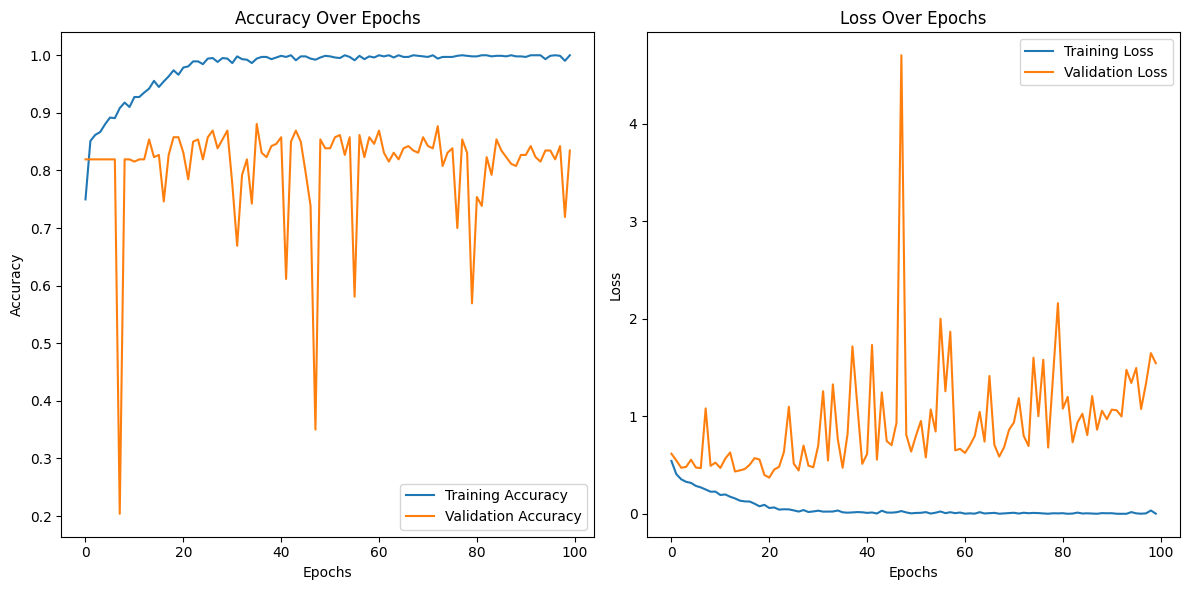

Entrenando en el Fold: 2
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4727 - accuracy: 0.8175 - auc: 0.5591
Epoch 1: val_auc improved from -inf to 0.64032, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_1.h5
33/33 [==============================] - 2s 28ms/step - loss: 0.4675 - accuracy: 0.8206 - auc: 0.5655 - val_loss: 0.5937 - val_accuracy: 0.8371 - val_auc: 0.6403
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4141 - accuracy: 0.8246 - auc: 0.7377
Epoch 2: val_auc did not improve from 0.64032
33/33 [==============================] - 1s 24ms/step - loss: 0.4136 - accuracy: 0.8254 - auc: 0.7359 - val_loss: 0.5452 - val_accuracy: 0.8371 - val_auc: 0.5806
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3612 - accuracy: 0.8438 - auc: 0.8192
Epoch 3: val_auc did not improve from 0.64032
33/33 [==============================] - 1s 23ms/step - loss: 0.3616 - accuracy: 0.8419 - auc

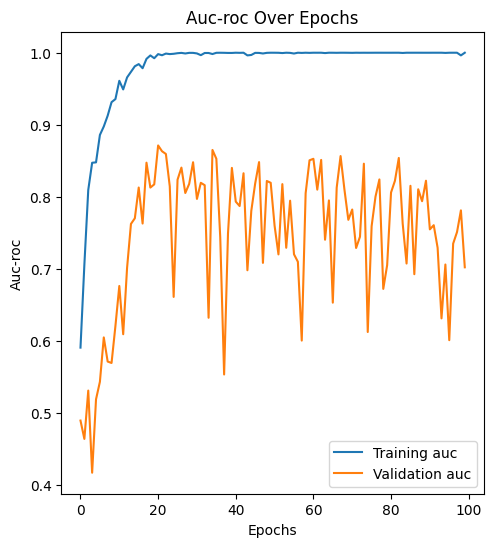

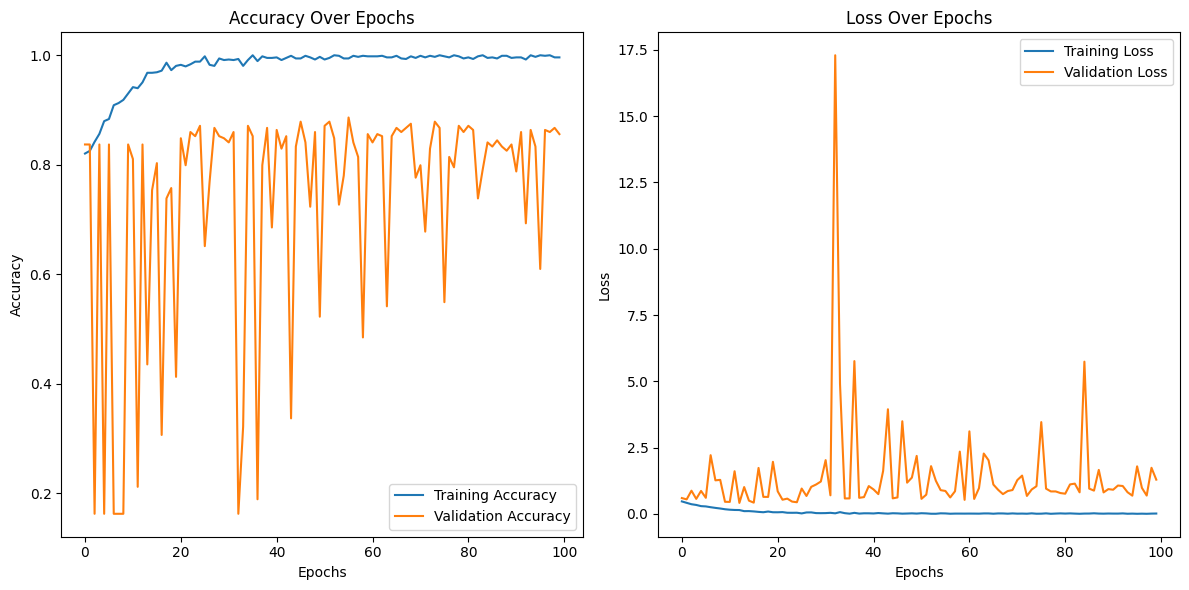

Entrenando en el Fold: 3
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4788 - accuracy: 0.8145 - auc: 0.5967
Epoch 1: val_auc improved from -inf to 0.55012, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_2.h5
33/33 [==============================] - 2s 28ms/step - loss: 0.4770 - accuracy: 0.8156 - auc: 0.5965 - val_loss: 0.5866 - val_accuracy: 0.8425 - val_auc: 0.5501
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8338 - auc: 0.7604
Epoch 2: val_auc improved from 0.55012 to 0.60970, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_2.h5
33/33 [==============================] - 1s 25ms/step - loss: 0.4041 - accuracy: 0.8338 - auc: 0.7604 - val_loss: 0.6668 - val_accuracy: 0.8425 - val_auc: 0.6097
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8549 - auc: 0.8279
Epoch 3: val_auc improved from 0.60970 to 0

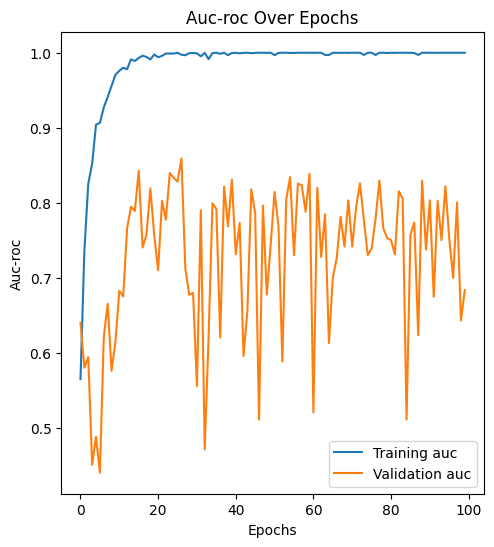

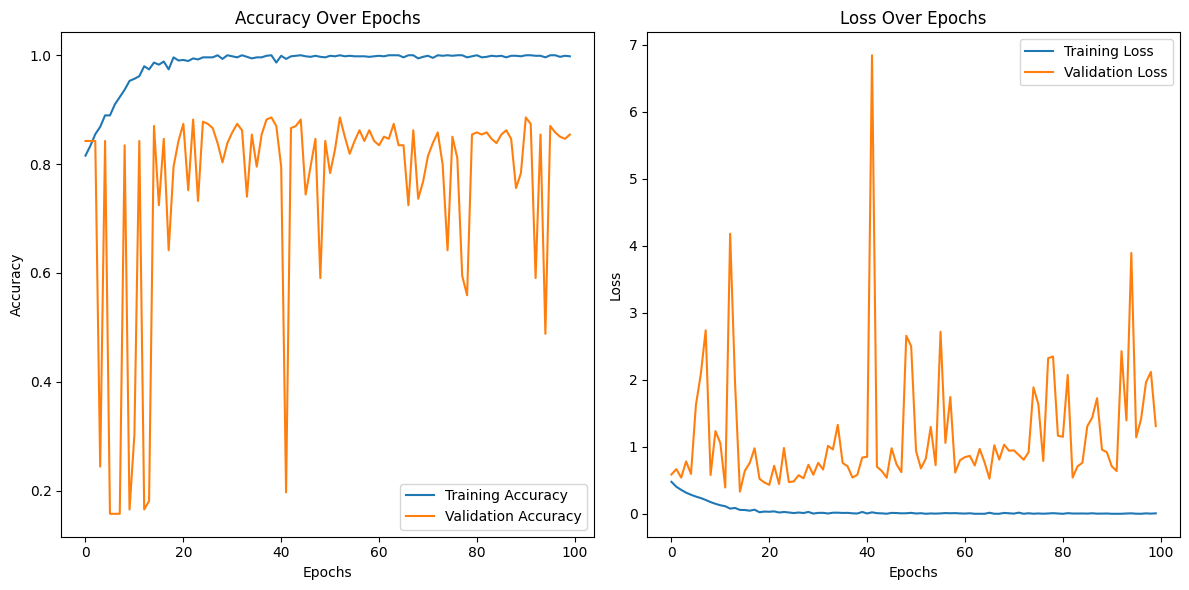

Entrenando en el Fold: 4
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8136 - auc: 0.6496
Epoch 1: val_auc improved from -inf to 0.50231, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_3.h5
33/33 [==============================] - 3s 44ms/step - loss: 0.4675 - accuracy: 0.8136 - auc: 0.6496 - val_loss: 0.5690 - val_accuracy: 0.8340 - val_auc: 0.5023
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3873 - accuracy: 0.8367 - auc: 0.7805
Epoch 2: val_auc improved from 0.50231 to 0.53651, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_3.h5
33/33 [==============================] - 1s 22ms/step - loss: 0.3871 - accuracy: 0.8369 - auc: 0.7816 - val_loss: 0.5521 - val_accuracy: 0.8340 - val_auc: 0.5365
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8466 - auc: 0.8269
Epoch 3: val_auc improved from 0.53651 to 0

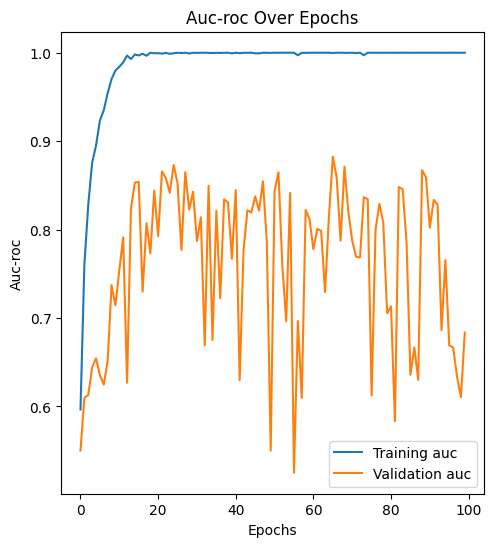

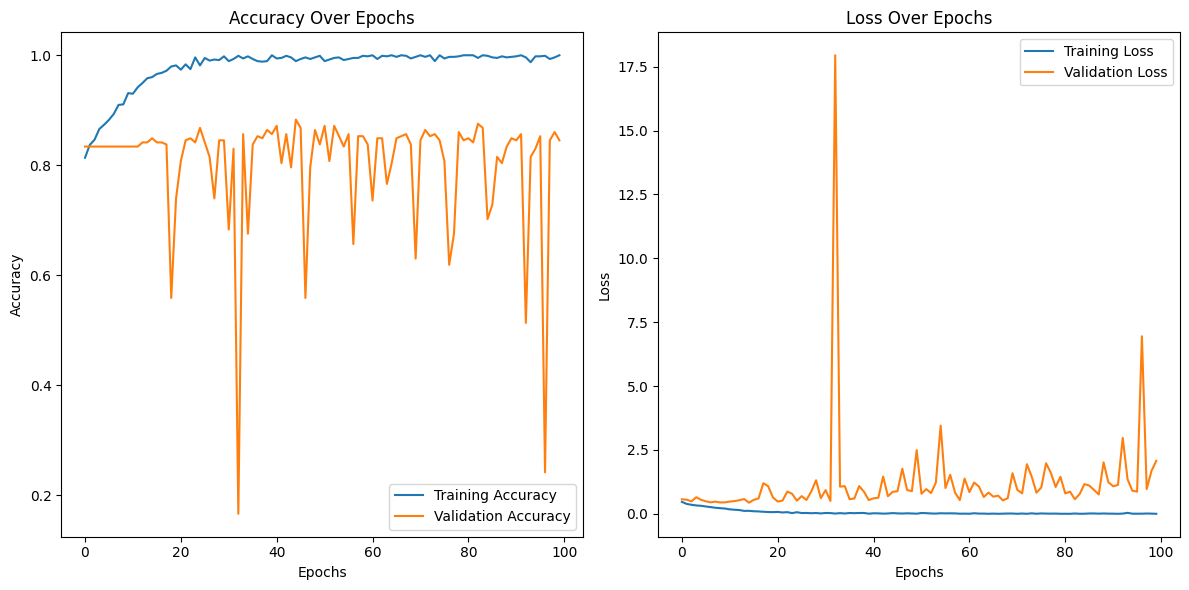

Entrenando en el Fold: 5
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.6115 - accuracy: 0.6855 - auc: 0.5210
Epoch 1: val_auc improved from -inf to 0.51857, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_4.h5
33/33 [==============================] - 2s 31ms/step - loss: 0.6054 - accuracy: 0.6913 - auc: 0.5288 - val_loss: 0.6448 - val_accuracy: 0.8175 - val_auc: 0.5186
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4363 - accuracy: 0.8296 - auc: 0.6644
Epoch 2: val_auc improved from 0.51857 to 0.56522, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2/only_t2_fold_4.h5
33/33 [==============================] - 1s 26ms/step - loss: 0.4339 - accuracy: 0.8313 - auc: 0.6630 - val_loss: 0.5528 - val_accuracy: 0.8175 - val_auc: 0.5652
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8360 - auc: 0.7332
Epoch 3: val_auc did not improve from 0.565

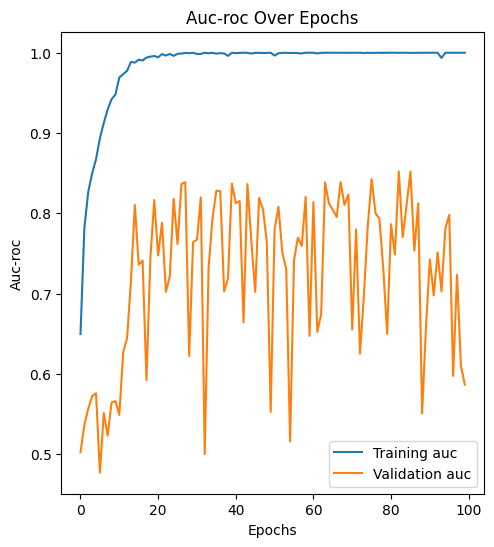

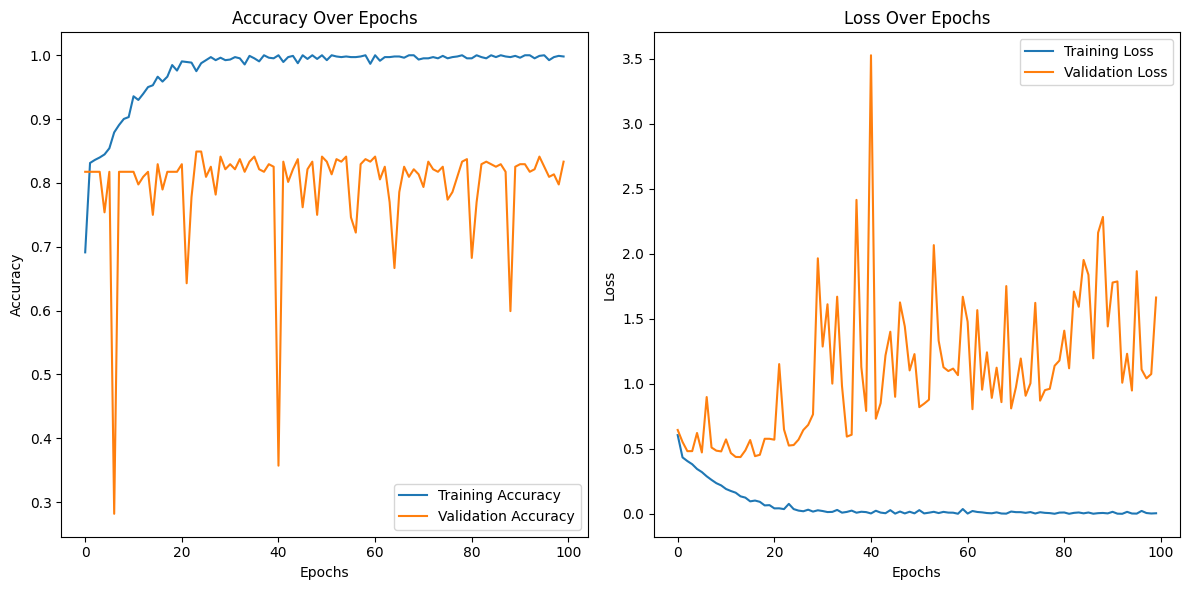

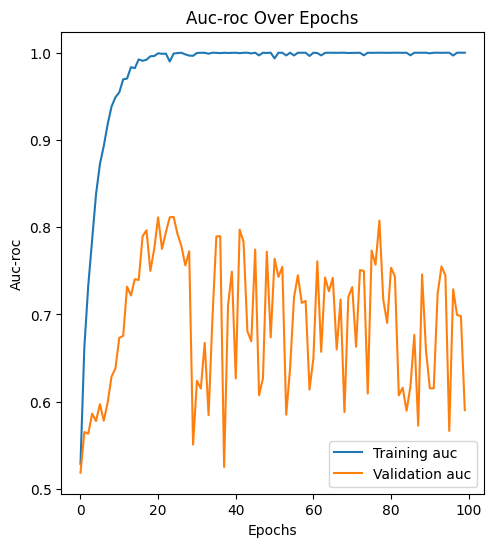

In [20]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2'
os.makedirs(save_dir, exist_ok=True)

for kfold_number in range(5):
    print(f"Entrenando en el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_train = np.transpose(X_train, (0, 2, 3, 4, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Crear el modelo
    model = create_model_t2()

    model.optimizer.build(model.trainable_variables)

    # Crear el callback para guardar el mejor modelo
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'only_t2_fold_{kfold_number}.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Ajustar el modelo
    history = model.fit(
        X_train[..., 0], 
        Y_train, 
        epochs=100, 
        validation_data=(X_val[..., 0], Y_val), 
        batch_size=32,
        callbacks=[checkpoint_callback]
    )
    plot_curves()


# Metric Report

In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_t2'

for kfold_number in range(5):
    print(f"Generando informe para el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Cargar el modelo
    model = load_model(os.path.join(save_dir, f'only_t2_fold_{kfold_number}.h5'))

    # Predecir las etiquetas de los datos de validación
    Y_pred = model.predict(X_val[..., 0])

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(Y_val, Y_pred)

    # Redondear las predicciones para calcular precisión, recall y accuracy
    Y_pred = np.round(Y_pred)

    # Generar el informe de clasificación
    report = classification_report(Y_val, Y_pred, target_names=['Clase 0', 'Clase 1'])

    print(f"Informe para el Fold {kfold_number + 1}:\n{report}")
    print(f"AUC-ROC: {auc_roc}\n")


Generando informe para el Fold: 1
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 1:
              precision    recall  f1-score   support

     Clase 0       0.92      0.87      0.89       213
     Clase 1       0.53      0.66      0.58        47

    accuracy                           0.83       260
   macro avg       0.72      0.76      0.74       260
weighted avg       0.85      0.83      0.84       260

AUC-ROC: 0.8698431725102388

Generando informe para el Fold: 2
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 2:
              precision    recall  f1-score   support

     Clase 0       0.97      0.75      0.84       221
     Clase 1       0.40      0.86      0.55        43

    accuracy                           0.77       264
   macro avg       0.68      0.81      0.70       264
weighted avg       0.87      0.77      0.80       264

AUC-ROC: 0.8608860359886352

Generando informe para el Fold: 3
8/8 [==============================]

# Solo con ADC

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def create_model_adc():
    input_shape = (12, 32, 32, 1)  # Input shape for each modality

    # Define a function to create a branch of the model
    def create_branch_adc():
        branch = tf.keras.models.Sequential([
            tf.keras.layers.Conv3D(filters=8, kernel_size=(1,3,3), padding='SAME', input_shape=input_shape, dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=8, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(2,2,2)),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=64, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.GlobalAveragePooling3D()
        ])
        return branch

    # Create a branch for the adc modality
    adc_branch = create_branch_adc()

    # Create input for the branch
    adc_input = tf.keras.layers.Input(input_shape)

    # Pass input through the branch
    adc_embedding = adc_branch(adc_input)

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(adc_embedding)

    # Create the model
    model = tf.keras.models.Model(inputs=adc_input, outputs=output)
    
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model



Entrenando en el Fold: 1
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4302 - accuracy: 0.8226 - auc: 0.8069
Epoch 1: val_auc improved from -inf to 0.40356, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_0.h5
33/33 [==============================] - 2s 31ms/step - loss: 0.4254 - accuracy: 0.8251 - auc: 0.8107 - val_loss: 0.5364 - val_accuracy: 0.8192 - val_auc: 0.4036
Epoch 2/100
 7/33 [=====>........................] - ETA: 0s - loss: 0.2995 - accuracy: 0.8973 - auc: 0.8912

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8754 - auc: 0.8911
Epoch 2: val_auc improved from 0.40356 to 0.44266, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_0.h5
33/33 [==============================] - 1s 26ms/step - loss: 0.3022 - accuracy: 0.8754 - auc: 0.8911 - val_loss: 0.4948 - val_accuracy: 0.8192 - val_auc: 0.4427
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2537 - accuracy: 0.8921 - auc: 0.9258
Epoch 3: val_auc improved from 0.44266 to 0.47343, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_0.h5
33/33 [==============================] - 1s 21ms/step - loss: 0.2571 - accuracy: 0.8899 - auc: 0.9216 - val_loss: 0.5007 - val_accuracy: 0.8192 - val_auc: 0.4734
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2185 - accuracy: 0.9143 - auc: 0.9413
Epoch 4: val_auc improved from 0.47343 to 0.74148, saving model to /home/

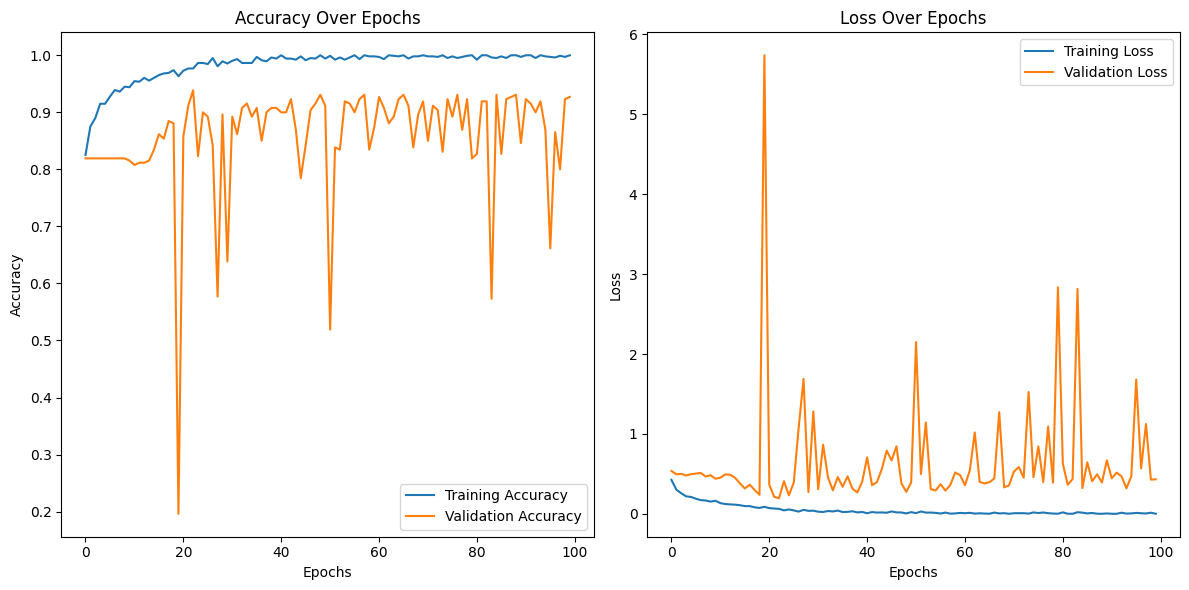

Entrenando en el Fold: 2
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4491 - accuracy: 0.8125 - auc: 0.7832
Epoch 1: val_auc improved from -inf to 0.31943, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_1.h5
33/33 [==============================] - 2s 30ms/step - loss: 0.4438 - accuracy: 0.8157 - auc: 0.7881 - val_loss: 0.5237 - val_accuracy: 0.8371 - val_auc: 0.3194
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3230 - accuracy: 0.8700 - auc: 0.8771
Epoch 2: val_auc did not improve from 0.31943
33/33 [==============================] - 1s 24ms/step - loss: 0.3193 - accuracy: 0.8710 - auc: 0.8809 - val_loss: 0.4889 - val_accuracy: 0.8371 - val_auc: 0.2800
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8962 - auc: 0.9210
Epoch 3: val_auc improved from 0.31943 to 0.38404, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fol

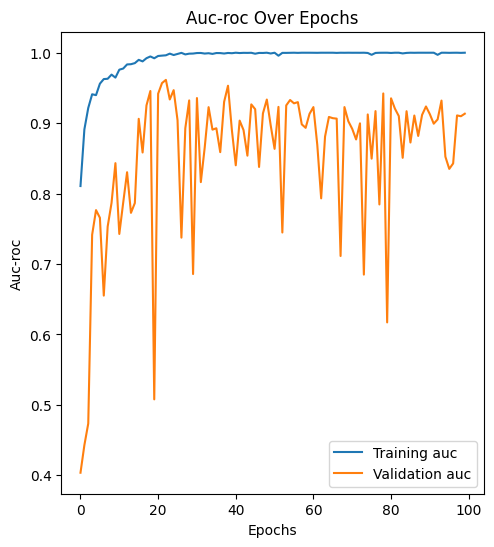

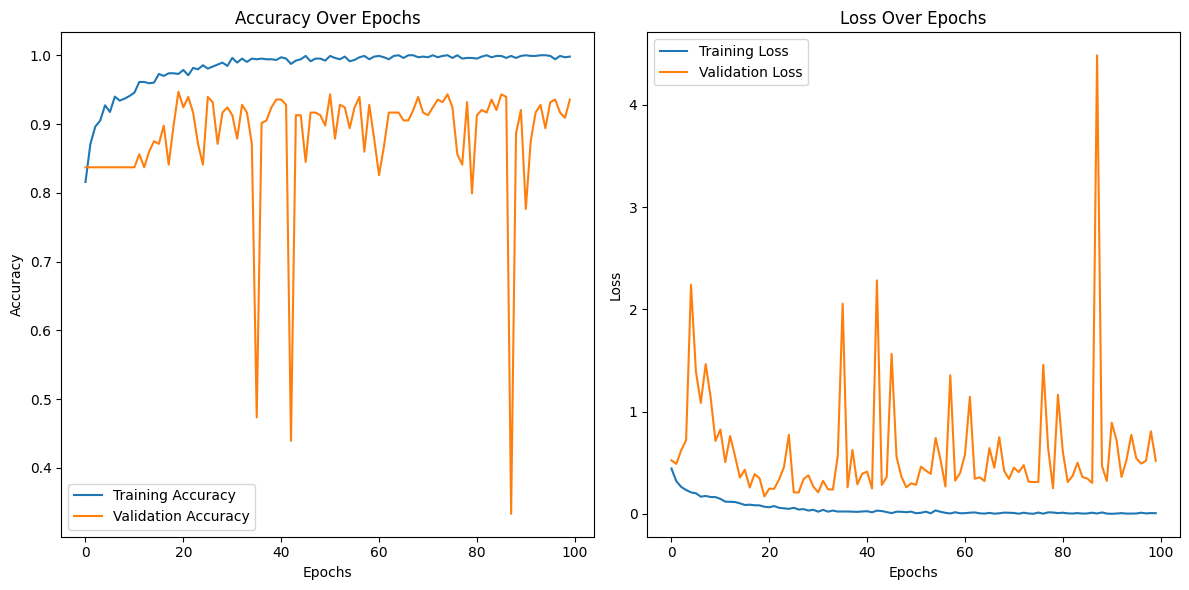

Entrenando en el Fold: 3
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5611 - accuracy: 0.7510 - auc: 0.7723
Epoch 1: val_auc improved from -inf to 0.53037, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_2.h5
33/33 [==============================] - 2s 27ms/step - loss: 0.5490 - accuracy: 0.7589 - auc: 0.7824 - val_loss: 0.5724 - val_accuracy: 0.8425 - val_auc: 0.5304
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3247 - accuracy: 0.8810 - auc: 0.8897
Epoch 2: val_auc improved from 0.53037 to 0.63259, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_2.h5
33/33 [==============================] - 1s 25ms/step - loss: 0.3273 - accuracy: 0.8790 - auc: 0.8850 - val_loss: 0.4591 - val_accuracy: 0.8425 - val_auc: 0.6326
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2768 - accuracy: 0.8877 - auc: 0.9113
Epoch 3: val_auc improved from 0.63259 

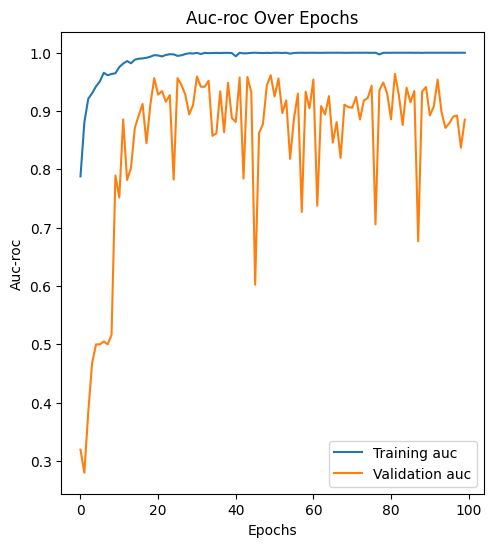

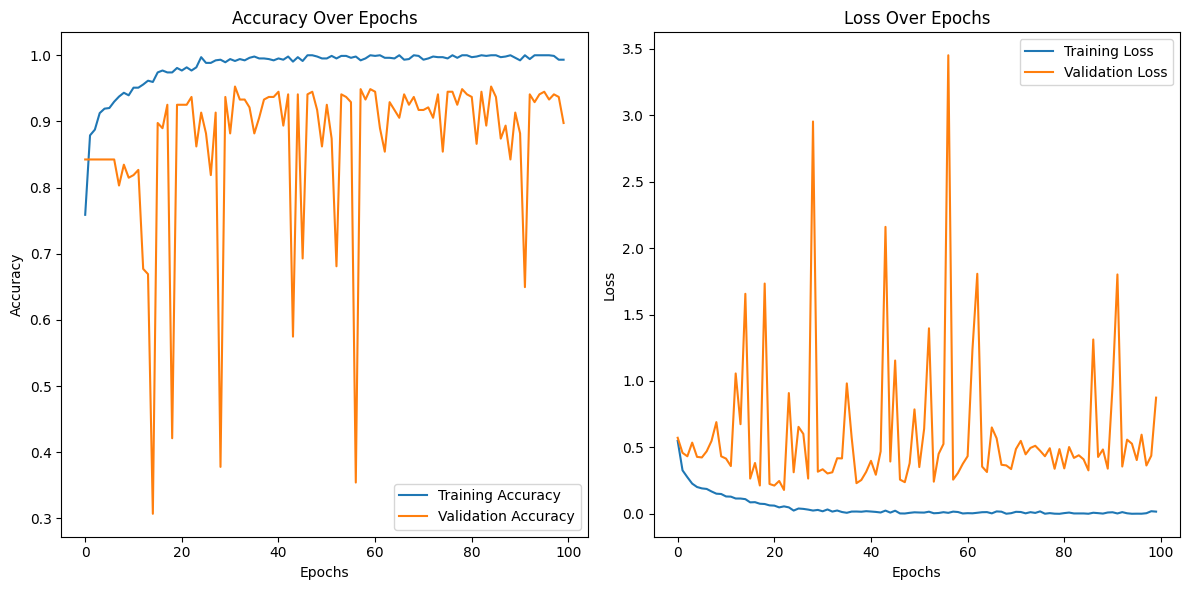

Entrenando en el Fold: 4
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3965 - accuracy: 0.8458 - auc: 0.8364
Epoch 1: val_auc improved from -inf to 0.38462, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_3.h5
33/33 [==============================] - 2s 29ms/step - loss: 0.3939 - accuracy: 0.8466 - auc: 0.8380 - val_loss: 0.5092 - val_accuracy: 0.8340 - val_auc: 0.3846
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2885 - accuracy: 0.8921 - auc: 0.9097
Epoch 2: val_auc improved from 0.38462 to 0.72851, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_3.h5
33/33 [==============================] - 1s 22ms/step - loss: 0.2883 - accuracy: 0.8932 - auc: 0.9077 - val_loss: 0.4553 - val_accuracy: 0.8340 - val_auc: 0.7285
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2489 - accuracy: 0.9021 - auc: 0.9208
Epoch 3: val_auc did not improve from 0

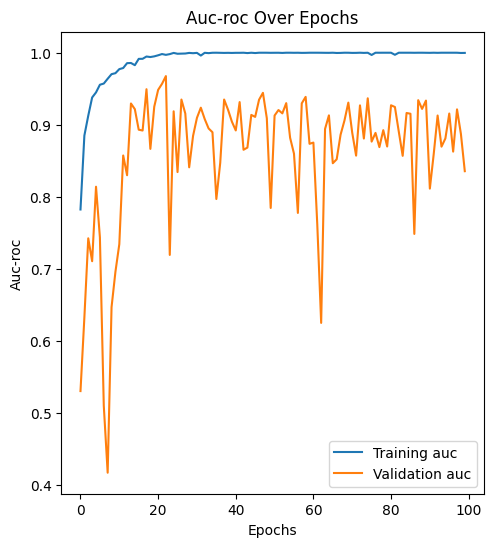

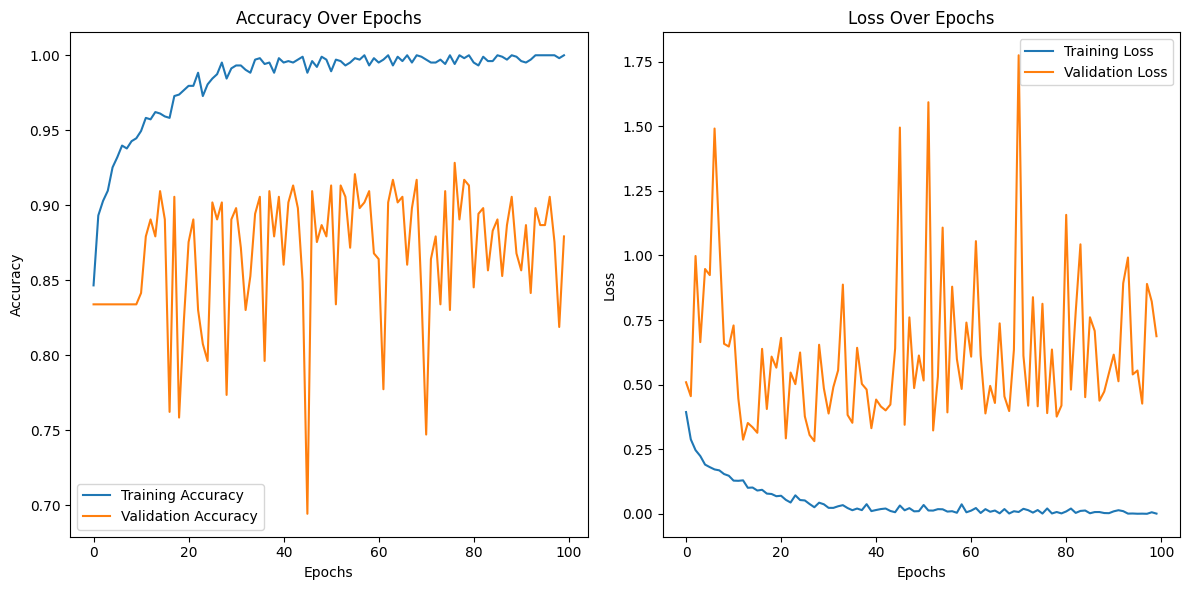

Entrenando en el Fold: 5
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4706 - accuracy: 0.7772 - auc: 0.7640
Epoch 1: val_auc improved from -inf to 0.47014, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_4.h5
33/33 [==============================] - 2s 29ms/step - loss: 0.4648 - accuracy: 0.7814 - auc: 0.7701 - val_loss: 0.6228 - val_accuracy: 0.8175 - val_auc: 0.4701
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3016 - accuracy: 0.8851 - auc: 0.8892
Epoch 2: val_auc improved from 0.47014 to 0.65539, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc/only_adc_fold_4.h5
33/33 [==============================] - 1s 24ms/step - loss: 0.3026 - accuracy: 0.8821 - auc: 0.8907 - val_loss: 0.4749 - val_accuracy: 0.8175 - val_auc: 0.6554
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9062 - auc: 0.9377
Epoch 3: val_auc improved from 0.65539 

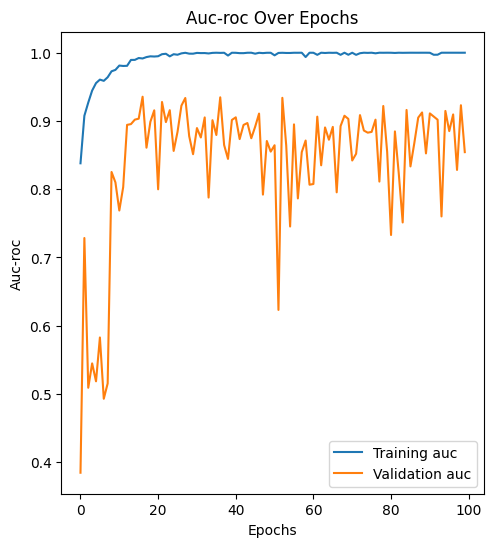

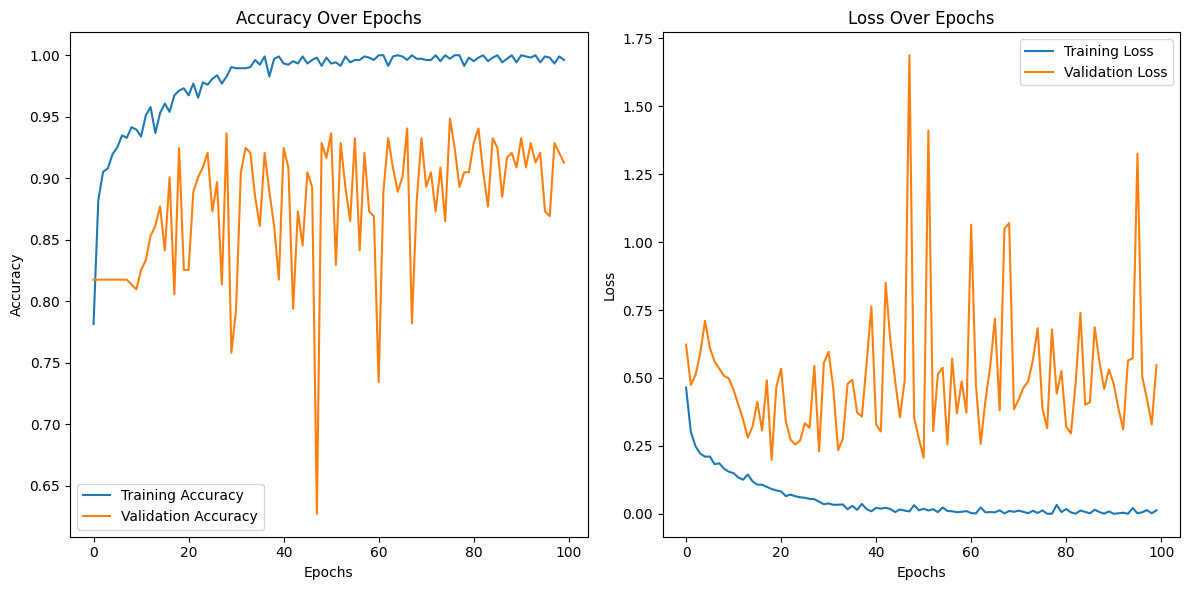

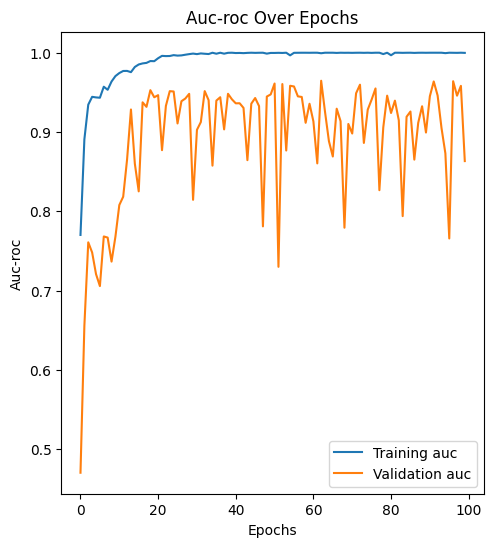

In [23]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc'
os.makedirs(save_dir, exist_ok=True)

for kfold_number in range(5):
    print(f"Entrenando en el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_train = np.transpose(X_train, (0, 2, 3, 4, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Crear el modelo
    model = create_model_adc()

    model.optimizer.build(model.trainable_variables)

    # Crear el callback para guardar el mejor modelo
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'only_adc_fold_{kfold_number}.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Ajustar el modelo
    history = model.fit(
        X_train[..., 1], 
        Y_train, 
        epochs=100, 
        validation_data=(X_val[..., 1], Y_val), 
        batch_size=32,
        callbacks=[checkpoint_callback]
    )
    plot_curves()


# Metrics Report

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_adc'

for kfold_number in range(5):
    print(f"Generando informe para el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Cargar el modelo
    model = load_model(os.path.join(save_dir, f'only_adc_fold_{kfold_number}.h5'))

    # Predecir las etiquetas de los datos de validación
    Y_pred = model.predict(X_val[..., 1])

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(Y_val, Y_pred)

    # Redondear las predicciones para calcular precisión, recall y accuracy
    Y_pred = np.round(Y_pred)

    # Generar el informe de clasificación
    report = classification_report(Y_val, Y_pred, target_names=['Clase 0', 'Clase 1'])

    print(f"Informe para el Fold {kfold_number + 1}:\n{report}")
    print(f"AUC-ROC: {auc_roc}\n")


Generando informe para el Fold: 1
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 1:
              precision    recall  f1-score   support

     Clase 0       0.94      0.99      0.96       213
     Clase 1       0.92      0.72      0.81        47

    accuracy                           0.94       260
   macro avg       0.93      0.85      0.89       260
weighted avg       0.94      0.94      0.94       260

AUC-ROC: 0.9612426331035862

Generando informe para el Fold: 2
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 2:
              precision    recall  f1-score   support

     Clase 0       0.97      0.93      0.95       221
     Clase 1       0.71      0.86      0.78        43

    accuracy                           0.92       264
   macro avg       0.84      0.90      0.87       264
weighted avg       0.93      0.92      0.92       264

AUC-ROC: 0.9601178575186783

Generando informe para el Fold: 3
8/8 [==============================]

# Only B-VAL

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def create_model_bval():
    input_shape = (12, 32, 32, 1)  # Input shape for each modality

    # Define a function to create a branch of the model
    def create_branch_bval():
        branch = tf.keras.models.Sequential([
            tf.keras.layers.Conv3D(filters=8, kernel_size=(1,3,3), padding='SAME', input_shape=input_shape, dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=8, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(2,2,2)),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool3D(pool_size=(1,2,2)),
            tf.keras.layers.Conv3D(filters=64, kernel_size=(1,3,3), padding='SAME', dtype=tf.float64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.GlobalAveragePooling3D()
        ])
        return branch

    # Create a branch for the bval modality
    bval_branch = create_branch_bval()

    # Create input for the branch
    bval_input = tf.keras.layers.Input(input_shape)

    # Pass input through the branch
    bval_embedding = bval_branch(bval_input)

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(bval_embedding)

    # Create the model
    model = tf.keras.models.Model(inputs=bval_input, outputs=output)
    
    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model



Entrenando en el Fold: 1
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4866 - accuracy: 0.8115 - auc: 0.6422
Epoch 1: val_auc improved from -inf to 0.51518, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_0.h5
33/33 [==============================] - 2s 31ms/step - loss: 0.4860 - accuracy: 0.8116 - auc: 0.6414 - val_loss: 0.6079 - val_accuracy: 0.8192 - val_auc: 0.5152
Epoch 2/100
 7/33 [=====>........................] - ETA: 0s - loss: 0.3366 - accuracy: 0.8929 - auc: 0.8108

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/33 [===========================>..] - ETA: 0s - loss: 0.3625 - accuracy: 0.8639 - auc: 0.7913
Epoch 2: val_auc improved from 0.51518 to 0.64869, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_0.h5
33/33 [==============================] - 1s 24ms/step - loss: 0.3686 - accuracy: 0.8609 - auc: 0.7826 - val_loss: 0.5234 - val_accuracy: 0.8192 - val_auc: 0.6487
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3251 - accuracy: 0.8740 - auc: 0.8506
Epoch 3: val_auc did not improve from 0.64869
33/33 [==============================] - 1s 24ms/step - loss: 0.3233 - accuracy: 0.8734 - auc: 0.8565 - val_loss: 0.4867 - val_accuracy: 0.8192 - val_auc: 0.6174
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3042 - accuracy: 0.8841 - auc: 0.8627
Epoch 4: val_auc improved from 0.64869 to 0.70872, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_0.h5
33/33 [================

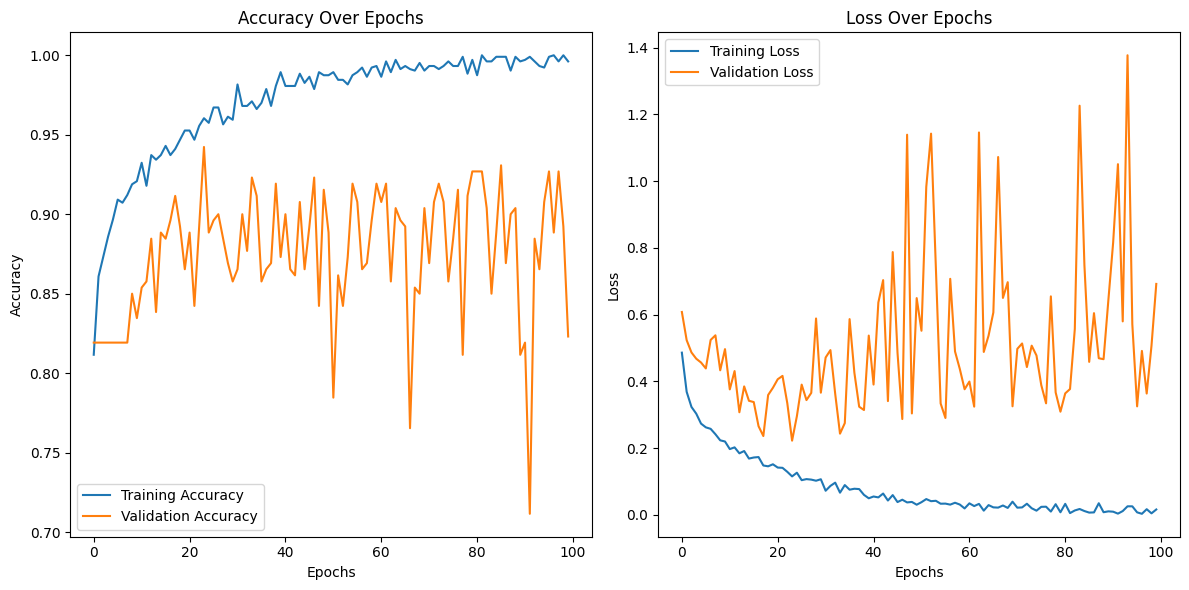

Entrenando en el Fold: 2
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4684 - accuracy: 0.8135 - auc: 0.6557
Epoch 1: val_auc improved from -inf to 0.43713, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_1.h5
33/33 [==============================] - 2s 30ms/step - loss: 0.4673 - accuracy: 0.8138 - auc: 0.6599 - val_loss: 0.5949 - val_accuracy: 0.8371 - val_auc: 0.4371
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3552 - accuracy: 0.8649 - auc: 0.8138
Epoch 2: val_auc improved from 0.43713 to 0.54272, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_1.h5
33/33 [==============================] - 1s 25ms/step - loss: 0.3579 - accuracy: 0.8642 - auc: 0.8060 - val_loss: 0.4918 - val_accuracy: 0.8371 - val_auc: 0.5427
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3165 - accuracy: 0.8861 - auc: 0.8552
Epoch 3: val_auc improved from 0.54

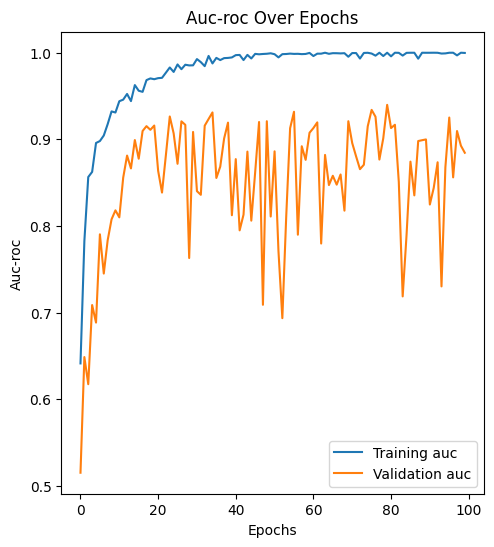

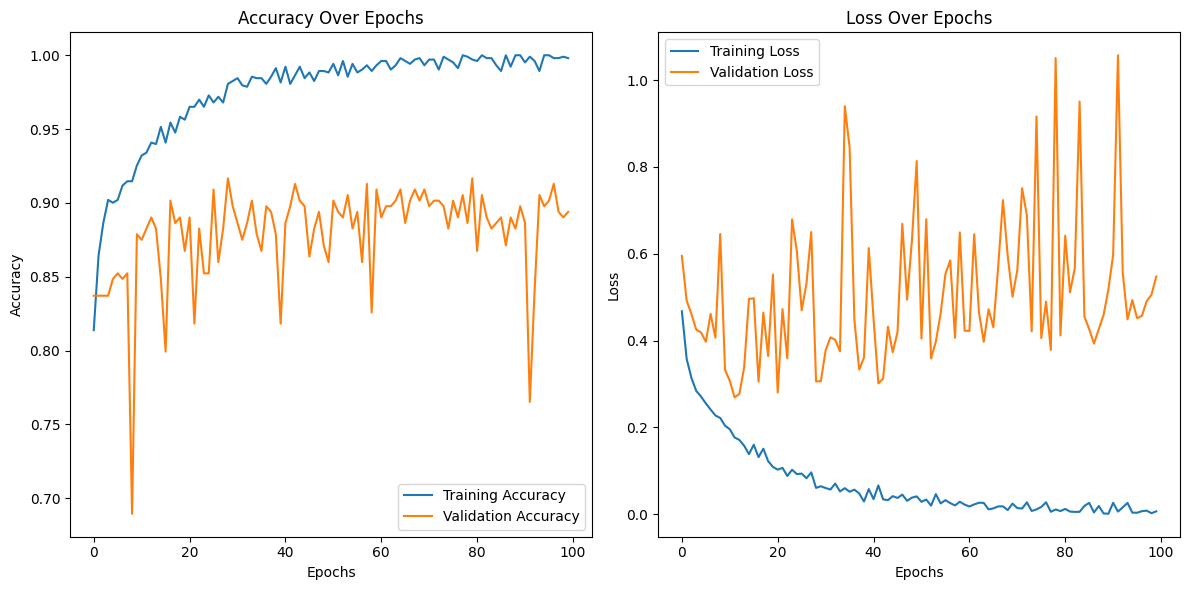

Entrenando en el Fold: 3
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.8204 - auc: 0.6864
Epoch 1: val_auc improved from -inf to 0.45304, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_2.h5
33/33 [==============================] - 2s 30ms/step - loss: 0.4493 - accuracy: 0.8204 - auc: 0.6864 - val_loss: 0.4855 - val_accuracy: 0.8425 - val_auc: 0.4530
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8516 - auc: 0.7882
Epoch 2: val_auc improved from 0.45304 to 0.46916, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_2.h5
33/33 [==============================] - 1s 26ms/step - loss: 0.3722 - accuracy: 0.8511 - auc: 0.7875 - val_loss: 0.4455 - val_accuracy: 0.8425 - val_auc: 0.4692
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3534 - accuracy: 0.8579 - auc: 0.8087
Epoch 3: val_auc improved from 0.46

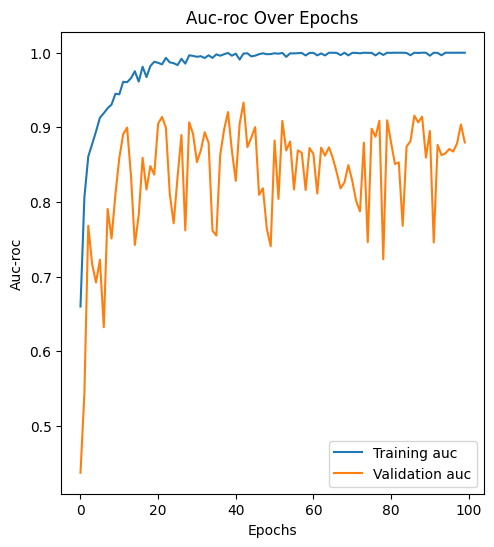

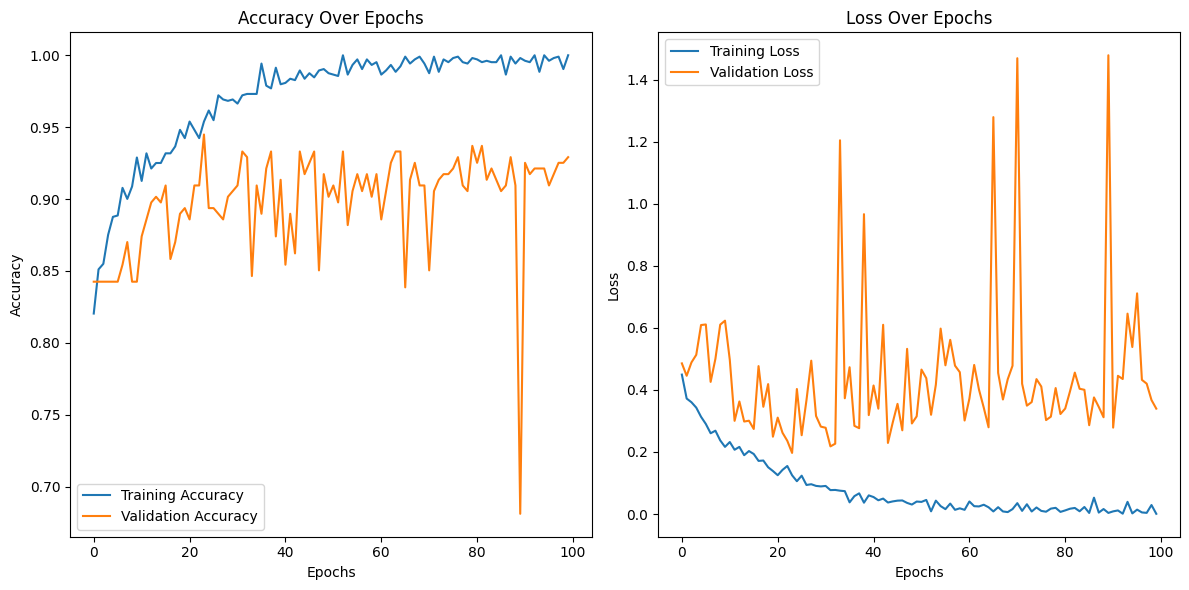

Entrenando en el Fold: 4
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4921 - accuracy: 0.8125 - auc: 0.6608
Epoch 1: val_auc improved from -inf to 0.57949, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_3.h5
33/33 [==============================] - 2s 32ms/step - loss: 0.4866 - accuracy: 0.8146 - auc: 0.6678 - val_loss: 0.5165 - val_accuracy: 0.8340 - val_auc: 0.5795
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4028 - accuracy: 0.8397 - auc: 0.7369
Epoch 2: val_auc improved from 0.57949 to 0.59081, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_3.h5
33/33 [==============================] - 1s 23ms/step - loss: 0.4017 - accuracy: 0.8379 - auc: 0.7432 - val_loss: 0.4487 - val_accuracy: 0.8340 - val_auc: 0.5908
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8524 - auc: 0.8029
Epoch 3: val_auc improved from 0.59

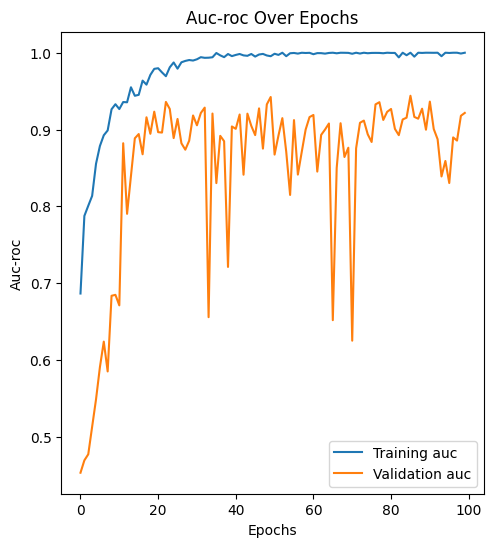

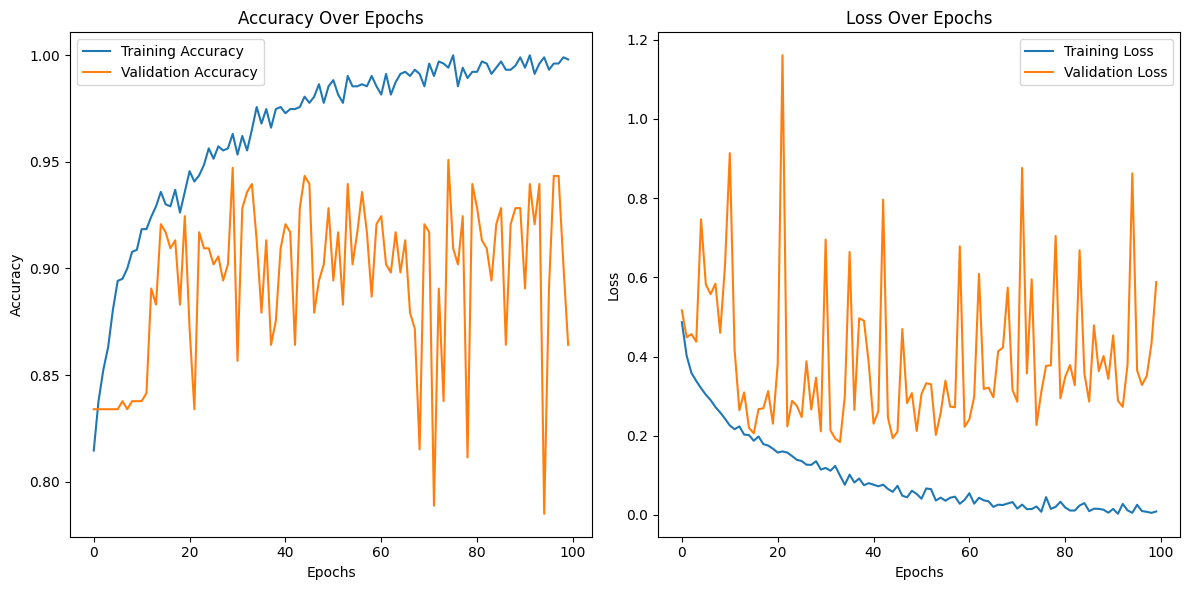

Entrenando en el Fold: 5
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8332 - auc: 0.6715
Epoch 1: val_auc improved from -inf to 0.65138, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval_fold_4.h5
33/33 [==============================] - 2s 28ms/step - loss: 0.4274 - accuracy: 0.8332 - auc: 0.6715 - val_loss: 0.5262 - val_accuracy: 0.8175 - val_auc: 0.6514
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3436 - accuracy: 0.8548 - auc: 0.8286
Epoch 2: val_auc did not improve from 0.65138
33/33 [==============================] - 1s 22ms/step - loss: 0.3526 - accuracy: 0.8485 - auc: 0.8175 - val_loss: 0.5234 - val_accuracy: 0.8175 - val_auc: 0.6406
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3186 - accuracy: 0.8669 - auc: 0.8577
Epoch 3: val_auc improved from 0.65138 to 0.66806, saving model to /home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval/only_bval

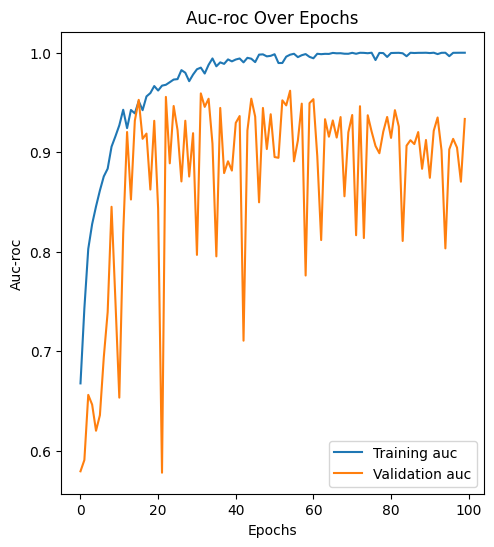

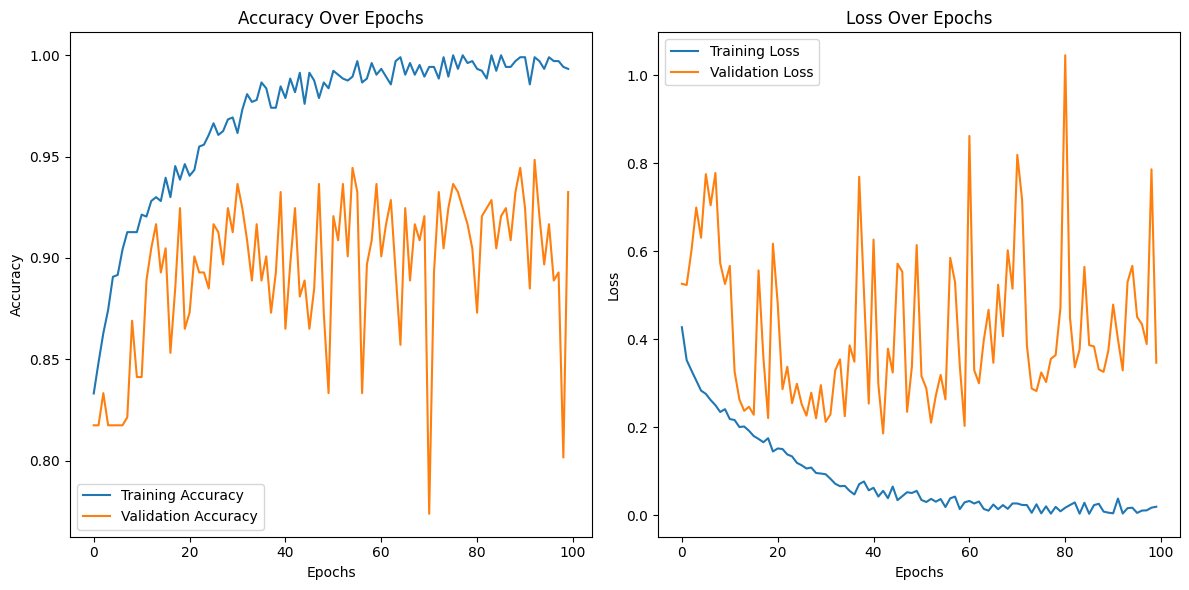

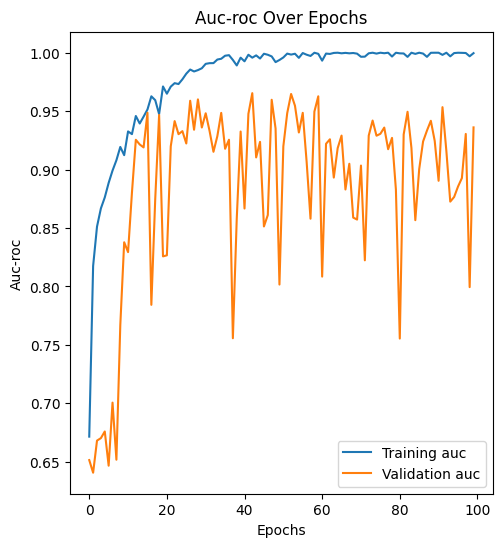

In [27]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval'
os.makedirs(save_dir, exist_ok=True)

for kfold_number in range(5):
    print(f"Entrenando en el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_train = np.transpose(X_train, (0, 2, 3, 4, 1))
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Crear el modelo
    model = create_model_bval()

    model.optimizer.build(model.trainable_variables)

    # Crear el callback para guardar el mejor modelo
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'only_bval_fold_{kfold_number}.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Ajustar el modelo
    history = model.fit(
        X_train[..., 2], 
        Y_train, 
        epochs=100, 
        validation_data=(X_val[..., 2], Y_val), 
        batch_size=32,
        callbacks=[checkpoint_callback]
    )
    plot_curves()


# Metrics Report

In [28]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Crear la carpeta si no existe
save_dir = '/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/only_bval'

for kfold_number in range(5):
    print(f"Generando informe para el Fold: {kfold_number + 1}")
    X_train, X_val, Y_train, Y_val, _, _ = get_fold_of_data(kfold_number)
    X_val = np.transpose(X_val, (0, 2, 3, 4, 1))

    # Cargar el modelo
    model = load_model(os.path.join(save_dir, f'only_bval_fold_{kfold_number}.h5'))

    # Predecir las etiquetas de los datos de validación
    Y_pred = model.predict(X_val[..., 2])

    # Calcular el AUC-ROC
    auc_roc = roc_auc_score(Y_val, Y_pred)

    # Redondear las predicciones para calcular precisión, recall y accuracy
    Y_pred = np.round(Y_pred)

    # Generar el informe de clasificación
    report = classification_report(Y_val, Y_pred, target_names=['Clase 0', 'Clase 1'])

    print(f"Informe para el Fold {kfold_number + 1}:\n{report}")
    print(f"AUC-ROC: {auc_roc}\n")


Generando informe para el Fold: 1
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 1:
              precision    recall  f1-score   support

     Clase 0       0.94      0.98      0.96       213
     Clase 1       0.87      0.70      0.78        47

    accuracy                           0.93       260
   macro avg       0.90      0.84      0.87       260
weighted avg       0.92      0.93      0.92       260

AUC-ROC: 0.9385675756667665

Generando informe para el Fold: 2
9/9 [==============================] - 0s 6ms/step
Informe para el Fold 2:
              precision    recall  f1-score   support

     Clase 0       0.95      0.94      0.95       221
     Clase 1       0.72      0.77      0.74        43

    accuracy                           0.91       264
   macro avg       0.84      0.85      0.84       264
weighted avg       0.92      0.91      0.91       264

AUC-ROC: 0.9352835946543196

Generando informe para el Fold: 3
8/8 [==============================]

In [7]:
X_train[..., 2].shape

(1031, 3, 12, 32)

In [ ]:
'/home/jaolmosr_pupils/Cesar/CesarIA2/Experiments/'

In [ ]:
print("¿Está TensorFlow utilizando la GPU?", "Sí" if tf.test.is_gpu_available() else "No")
